In [ ]:
# Install Together API SDK
!pip install together

In [ ]:
!pip install fpdf PyPDF2

In [ ]:
from together import Together
from fpdf import FPDF
import textwrap
import csv
import os
import time
import json
from datetime import datetime
from PyPDF2 import PdfMerger

# Function to read JSON data from file
def read_json_from_file(file_path):
    """Reads JSON data from a file."""
    try:
        with open(file_path, 'r', encoding="utf-8") as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"❌ Error: File not found at '{file_path}'")
        return None
    except json.JSONDecodeError:
        print(f"❌ Error: Invalid JSON format in '{file_path}'")
        return None

# Define the API Key
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")  # Ensure the API key is correctly fetched
if not TOGETHER_API_KEY:
    print("❌ Error: TOGETHER_API_KEY is not set.")
    exit()

# Initialize Together AI Client
client = Together(api_key=TOGETHER_API_KEY)

# Define model and input file
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
file_path = "FineTuneResponse.json"  # Ensure the correct file path

# Read JSON data
prompts = read_json_from_file(file_path)
if not prompts:
    print("❌ Error: No prompts found in the JSON file.")
    exit()

# Generate timestamp for filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_filename = f"together_ai_responses.pdf"
csv_filename = f"together_ai_responses.csv"

# Write CSV Header
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(list(prompts[0].keys()) + ["Response"])  # Writing column headers

# Function to create PDF
def create_pdf(query, response, filename=pdf_filename, append=False):
    temp_filename = "temp_" + filename
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    # Add title
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(0, 10, "Together AI Responses", ln=True, align="C")
    pdf.ln(10)

    # Add query
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Query:", ln=True)
    pdf.ln(5)
    pdf.set_font("Arial", size=11)
    for line in textwrap.wrap(query, width=90):
        pdf.cell(0, 6, line, ln=True)
    pdf.ln(8)

    # Add response
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Response:", ln=True)
    pdf.ln(5)
    pdf.set_font("Arial", size=10)
    for line in textwrap.wrap(response, width=90):
        pdf.cell(0, 6, line, ln=True)
    pdf.ln(10)

    # Save the PDF
    pdf.output(temp_filename)

    # Merge PDFs if appending
    if append and os.path.exists(filename):
        merger = PdfMerger()
        merger.append(filename)
        merger.append(temp_filename)
        merger.write(filename)
        merger.close()
        os.remove(temp_filename)
    else:
        os.rename(temp_filename, filename)

# Process prompts
for i, prompt in enumerate(prompts):
    print(f"⏳ Processing prompt {i+1}/{len(prompts)}...")

    try:
        # Run Together AI inference
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": prompt["Question"]}],
            max_tokens=2000,
            temperature=0.9
        )

        # Extract response text
        response_text = response.choices[0].message.content.strip()

        # Write response to CSV
        with open(csv_filename, mode="a", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow(list(prompt.values()) + [response_text])

        # Save to PDF (Append after first query)
        create_pdf(prompt["Question"], response_text, pdf_filename, append=(i > 0))

        print(f"✔ Saved response {i+1} to {csv_filename} and {pdf_filename}")

        # Pause to avoid API rate limits
        time.sleep(2)

    except Exception as e:
        print(f"❌ Error processing prompt {i+1}: {e}")

print(f"\n✅ All prompts processed! Results saved to:\n📄 {pdf_filename}\n📊 {csv_filename}")


❌ Error: TOGETHER_API_KEY is not set.
⏳ Processing prompt 1/3...
✔ Saved response 1 to together_ai_responses.csv and together_ai_responses.pdf
⏳ Processing prompt 2/3...
✔ Saved response 2 to together_ai_responses.csv and together_ai_responses.pdf
⏳ Processing prompt 3/3...
✔ Saved response 3 to together_ai_responses.csv and together_ai_responses.pdf

✅ All prompts processed! Results saved to:
📄 together_ai_responses.pdf
📊 together_ai_responses.csv


In [ ]:
from together import Together
import json
import pandas as pd

import time
from google.colab import userdata

# Initialize Together API client
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
client = Together(api_key=TOGETHER_API_KEY)

import pandas as pd


# Assuming you uploaded a file named 'data.csv'
df = pd.read_csv("/content/together_ai_responses.csv")




def evaluate_questions(questions, retries=3):
    """
    Sends questions to LLM judge and returns structured evaluation results.

    Args:
        questions (list): List of assignment questions.
        retries (int): Number of retries in case of API failure.

    Returns:
        list: Evaluation results with scores and feedback.
    """

    evaluation_prompt = f"""
    You are an AI judge assessing assignment questions based on their:
    - **Relevance** (Does it match the provided topic and CLO?)
    - **Clarity** (Is the question well-structured and understandable?)
    - **Difficulty Alignment** (Does it match the expected difficulty level?)


    For each question, return:
    - "Query_ID"
    - "Question"
    - "CLO"
    - "Topic"
    - "Difficulty"
    - "Relevance Score" (Out of 10)
    - "Clarity Score" (Out of 10)
    - "Difficulty Score" (Out of 10)
    - "Overall Score" (Out of 10)
    - "Feedback" (Why it is or isn’t well-formed and how it can be improved)

    Assignment Questions:
    {json.dumps(questions, indent=2)}
    """

    evaluation_prompt_extend = f"""
    You are an AI judge assessing assignment questions based on the following criteria:
    - **Relevance**: Does the question align with the provided topic and Course Learning Outcomes (CLOs)?
    - **Clarity**: Is the question well-structured, grammatically correct, and easy to understand?
    - **Difficulty Alignment**: Does the question match the expected difficulty level (Easy, Intermediate, Hard)?
    - **Bloom’s Taxonomy Level**: Does the question align with cognitive skill levels (Recall, Understanding, Application, Analysis, Evaluation, Creation)?
    - **Completeness**: Does the question provide all necessary details (e.g., formulas, constraints, references) for a well-informed answer?
    - **Fairness and Bias**: Is the question free from cultural, gender, or contextual biases, ensuring equal accessibility for all students?
    - **Assessment Type Matching**: Is the question suitable for the assessment type (e.g., MCQs should have clear distractors, subjective questions should require critical thinking)?
    - **Grading Feasibility**: Can the question be objectively graded? If open-ended, does it have a clear expected answer format?
    - **Uniqueness and Non-Repetition**: Is the question diverse and non-redundant within the given question set?
    - **Real-World Applicability**: Does the question encourage practical application or connect to real-world scenarios?

    For each assignment question, only return
        "Query_ID": "<Unique Identifier>",
        "Question": "<Original Question>",
        "CLO": "<Course Learning Outcome>",
        "Topic": "<Related Topic>",
        "Difficulty": "<Easy/Intermediate/Hard>",
        "Relevance Score": "<Out of 10>",
        "Clarity Score": "<Out of 10>",
        "Difficulty Score": "<Out of 10>",
        "Bloom’s Taxonomy Level": "<Recall/Understanding/Application/Analysis/Evaluation/Creation>",
        "Completeness Score": "<Out of 10>",
        "Fairness & Bias Score": "<Out of 10>",
        "Assessment Type Matching Score": "<Out of 10>",
        "Grading Feasibility Score": "<Out of 10>",
        "Uniqueness & Non-Repetition Score": "<Out of 10>",
        "Real-World Applicability Score": "<Out of 10>",
        "Overall Score": "<Weighted Average Score Out of 10>",
        "Feedback": "<Detailed feedback on why the question is well-formed or how it can be improved>"

    Assignment Questions:
    {json.dumps(questions, indent=2)}
    """



    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-3B-Instruct-Turbo",
        messages=[{"role": "user", "content": evaluation_prompt_extend}],
        max_tokens=1000,
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0
    )

    return response.choices[0].message.content

# Step 1: Evaluate Questions Using LLM Judge
evaluation_results = evaluate_questions(dataset)

if not evaluation_results:
    print("Error: Evaluation failed. Exiting.")
    exit()



# Step 3: Display Results in a Structured Format
# tools.display_dataframe_to_user(name="LLM Judge Evaluation Results", dataframe=evaluation_df)
print("\nLLM Judge Evaluation Results:\n")
print(evaluation_results)


20330

LLM Judge Evaluation Results:

Query_ID: 1
Question: Design a system to solve a constraint satisfaction problem. Provide a practical example of how the system can be used.
CLO: Develop an algorithm to model and solve complex constraints in a programming system.
Topic: Constraint Satisfaction Problems
Difficulty: Hard
Relevance Score: 9
Clarity Score: 8
Difficulty Score: 9
Bloom’s Taxonomy Level: Analysis
Completeness Score: 9
Fairness & Bias Score: 10
Assessment Type Matching Score: 10
Grading Feasibility Score: 9
Uniqueness & Non-Repetition Score: 8
Real-World Applicability Score: 9
Overall Score: 8.4
Feedback: The question is well-structured and clearly defines the problem to be solved. It also provides a practical example of how the system can be used, which is a good way to demonstrate the relevance of the problem. However, the question could be improved by providing more specific constraints or requirements for the system, such as the type of constraints or the size of the 

In [ ]:
from together import Together
import json
import pandas as pd
import time
from google.colab import userdata

# Initialize Together API client
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
client = Together(api_key=TOGETHER_API_KEY)

# Load CSV file
csv_file_path = "/content/together_ai_responses.csv"
df = pd.read_csv(csv_file_path)

# Ensure the expected columns exist in the CSV
expected_columns = [ "Question" , "finetunedResponse","CLO", "Topic", "Difficulty"]
missing_columns = [col for col in expected_columns if col not in df.columns]

if missing_columns:
    raise ValueError(f"Missing columns in CSV: {missing_columns}")

# Convert DataFrame to list of dictionaries (JSON format)
questions_list = df[expected_columns].to_dict(orient="records")


def evaluate_questions(questions, retries=3):
    """
    Sends questions to LLM judge and returns structured evaluation results.

    Args:
        questions (list): List of assignment questions.
        retries (int): Number of retries in case of API failure.

    Returns:
        list: Evaluation results with scores and feedback.
    """

    evaluation_prompt = f"""
    You are an AI judge assessing assignment finetunedResponses based on the following criteria:
    - **Relevance**: Does the finetunedResponse align with the provided question topic and Course Learning Outcomes (CLOs)?
    - **Clarity**: Is the finetunedResponse well-structured, grammatically correct, and easy to understand?
    - **Difficulty Alignment**: Does the finetunedResponse match the expected difficulty level (Easy, Intermediate, Hard)?
    - **Bloom’s Taxonomy Level**: Does the finetunedResponse align with cognitive skill levels (Recall, Understanding, Application, Analysis, Evaluation, Creation)?
    - **Completeness**: Does the finetunedResponse provide all necessary details (e.g., formulas, constraints, references) for a well-informed answer?
    - **Assessment Type Matching**: Is the finetunedResponse suitable for the assessment type (e.g., MCQs should have clear distractors, subjective questions should require critical thinking)?
    - **Grading Feasibility**: Can the finetunedResponse be objectively graded? If open-ended, does it have a clear expected answer format?
    - **Uniqueness and Non-Repetition**: Is the finetunedResponse diverse and non-redundant within the given question set?
    - **Real-World Applicability**: Does the finetunedResponse encourage practical application or connect to real-world scenarios?

    For each assignment question, return:
    - "Query_ID": "<Unique Identifier>"
    - "Question": "<Original Question>"
    - "finetunedResponse": "<Original finetunedResponse>"
    - "CLO": "<Course Learning Outcome>"
    - "Topic": "<Related Topic>"
    - "Difficulty": "<Easy/Intermediate/Hard>"
    - "Relevance Score": "<Out of 10>"
    - "Clarity Score": "<Out of 10>"
    - "Difficulty Score": "<Out of 10>"
    - "Bloom’s Taxonomy Level": "<Recall/Understanding/Application/Analysis/Evaluation/Creation>"
    - "Completeness Score": "<Out of 10>"
    - "Fairness & Bias Score": "<Out of 10>"
    - "Assessment Type Matching Score": "<Out of 10>"
    - "Grading Feasibility Score": "<Out of 10>"
    - "Uniqueness & Non-Repetition Score": "<Out of 10>"
    - "Real-World Applicability Score": "<Out of 10>"
    - "Overall Score": "<Weighted Average Score Out of 10>"
    - "Feedback": "<Detailed feedback on why the question is well-formed or how it can be improved>"

    Assignment Questions:
    {json.dumps(questions, indent=2)}
    """

    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-3B-Instruct-Turbo",
        messages=[{"role": "user", "content": evaluation_prompt}],
        max_tokens=2000,
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0
    )

    return response.choices[0].message.content


# Step 1: Evaluate Questions Using LLM Judge
evaluation_results = evaluate_questions(questions_list)

if not evaluation_results:
    print("Error: Evaluation failed. Exiting.")
    exit()
print("Evaluation results:")
print(evaluation_results)
# Convert response to a structured DataFrame
# evaluation_data = json.loads(evaluation_results)
# evaluation_df = pd.DataFrame(evaluation_data)

# # Step 2: Save to CSV for further analysis
# evaluation_output_path = "/content/llm_evaluation_results.csv"
# evaluation_df.to_csv(evaluation_output_path, index=False)

# # Step 3: Print Results in a Structured Format
# print("\n### LLM Judge Evaluation Results ###\n")
# print(evaluation_df)

# print(f"\nEvaluation results saved to: {evaluation_output_path}")


Evaluation results:
Here are the assessments for each assignment question:

**Query_ID1**
"Question": "Design a system to solve a constraint satisfaction problem. Provide a practical example of how the system can be used.",
"finetunedResponse": "A constraint satisfaction problem (CSP) is a problem where we need to find an assignment of values to variables that satisfies a set of constraints. The CSP can be represented as a graph where nodes represent variables and edges represent constraints.\na) Define the CSP problem and explain its application in real-world scenarios.\nb) Implement a Python class to represent the CSP graph, including methods to add variables, constraints, and check satisfiability.\nc) Implement a constraint propagation algorithm (e.g., arc consistency) to optimize the CSP solving process.\nd) Extend your solution to support weighted constraints and explain how to handle conflicts between constraints.\ne) Analyze the performance of your implementation using a benchma

In [ ]:
from together import Together
import json
import pandas as pd
import time
from google.colab import userdata

# Initialize Together API client
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
client = Together(api_key=TOGETHER_API_KEY)

# Load CSV file
csv_file_path = "/content/together_ai_responses.csv"
df = pd.read_csv(csv_file_path)

# Ensure the expected columns exist in the CSV
expected_columns = [ "Question" , "Response","CLO", "Topic", "Difficulty"]
missing_columns = [col for col in expected_columns if col not in df.columns]

if missing_columns:
    raise ValueError(f"Missing columns in CSV: {missing_columns}")

# Convert DataFrame to list of dictionaries (JSON format)
questions_list = df[expected_columns].to_dict(orient="records")


def evaluate_questions(questions, retries=3):
    """
    Sends questions to LLM judge and returns structured evaluation results.

    Args:
        questions (list): List of assignment questions.
        retries (int): Number of retries in case of API failure.

    Returns:
        list: Evaluation results with scores and feedback.
    """

    evaluation_prompt = f"""
    You are an AI judge assessing assignment Responses based on the following criteria:
    - **Relevance**: Does the Response align with the provided question topic and Course Learning Outcomes (CLOs)?
    - **Clarity**: Is the Response well-structured, grammatically correct, and easy to understand?
    - **Difficulty Alignment**: Does the Response match the expected difficulty level (Easy, Intermediate, Hard)?
    - **Bloom’s Taxonomy Level**: Does the Response align with cognitive skill levels (Recall, Understanding, Application, Analysis, Evaluation, Creation)?
    - **Completeness**: Does the Response provide all necessary details (e.g., formulas, constraints, references) for a well-informed answer?
    - **Assessment Type Matching**: Is the Response suitable for the assessment type (e.g., Dont have soltuion inside)?
    - **Grading Feasibility**: Can the Response be objectively graded? If open-ended, does it have a clear expected answer format?
    - **Uniqueness and Non-Repetition**: Is the Response diverse and non-redundant within the given question set?
    - **Real-World Applicability**: Does the Response encourage practical application or connect to real-world scenarios?


    For each assignment question, return:
    - "Query_ID": "<Unique Identifier>"
    - "Question": "<Original Question>"
    - "LLMResponse": "<Original Response>"
    - "CLO": "<Course Learning Outcome>"
    - "Topic": "<Related Topic>"
    - "Difficulty": "<Easy/Intermediate/Hard>"
    - "Relevance Score": "<Out of 10>"
    - "Clarity Score": "<Out of 10>"
    - "Difficulty Score": "<Out of 10>"
    - "Bloom’s Taxonomy Level": "<Recall/Understanding/Application/Analysis/Evaluation/Creation>"
    - "Completeness Score": "<Out of 10>"
    - "Assessment Type Matching Score": "<Out of 10>"
    - "Grading Feasibility Score": "<Out of 10>"
    - "Uniqueness & Non-Repetition Score": "<Out of 10>"
    - "Real-World Applicability Score": "<Out of 10>"
    - "Overall Score": "<Weighted Average Score Out of 10>"
    - "Feedback": "<Detailed feedback on why the question is well-formed or how it can be improved>"

    Assignment Questions:
    {json.dumps(questions, indent=2)}
    """

    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-3B-Instruct-Turbo",
        messages=[{"role": "user", "content": evaluation_prompt}],
        max_tokens=2000,
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0
    )

    return response.choices[0].message.content


# Step 1: Evaluate Questions Using LLM Judge
evaluation_results = evaluate_questions(questions_list)

if not evaluation_results:
    print("Error: Evaluation failed. Exiting.")
    exit()
print("Evaluation results:")
print(evaluation_results)


Evaluation results:
Here's the assessment of the provided responses based on the given criteria:

**Query_ID**: 1
**Question**: Design a system to solve a constraint satisfaction problem. Provide a practical example of how the system can be used.
**LLMResponse**: ... (same as provided)
**CLO**: Develop an algorithm to model and solve complex constraints in a programming system.
**Topic**: Constraint Satisfaction Problems
**Difficulty**: hard
**Relevance Score**: 9/10 (The question and response are relevant to the topic and CLO)
**Clarity Score**: 9/10 (The response is well-structured and easy to understand)
**Difficulty Score**: 8/10 (The response is challenging, but the example of Sudoku makes it more understandable)
**Bloom’s Taxonomy Level**: Analysis
**Completeness Score**: 8/10 (The response provides a good example, but the algorithm implementation could be more detailed)
**Assessment Type Matching Score**: 10/10 (The response is suitable for an assessment of design and implementa

In [ ]:
from together import Together
import json
import pandas as pd
import time
from google.colab import userdata

# Initialize Together API client
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
client = Together(api_key=TOGETHER_API_KEY)

# Load CSV file
csv_file_path = "/content/together_ai_responses.csv"
df = pd.read_csv(csv_file_path)

# Ensure the expected columns exist in the CSV
expected_columns = ["Question", "Type", "Difficulty", "CLO", "Topic", "chunkNumber", "finetunedResponse", "Response"]
missing_columns = [col for col in expected_columns if col not in df.columns]

if missing_columns:
    raise ValueError(f"Missing columns in CSV: {missing_columns}")

# Convert DataFrame to list of dictionaries (JSON format)
responses_list = df[expected_columns].to_dict(orient="records")


def evaluate_responses(responses, retries=3):
    """
    Sends responses to LLM judge and returns structured evaluation results.

    Args:
        responses (list): List of responses to evaluate.
        retries (int): Number of retries in case of API failure.

    Returns:
        list: Evaluation results with scores and feedback.
    """

    evaluation_prompt = f"""
    You are an AI judge assessing AI-generated responses for assignment-style questions.
    Your goal is to determine which response is **more suitable for an assignment**, ensuring that it:
    - Does **not just provide the solution** but **follows an assignment format**.
    - Encourages critical thinking, explanations, and reasoning.
    - Aligns with the difficulty level and the Course Learning Outcome (CLO).

    **Evaluation Criteria:**
    - **Relevance**: Does the response align with the question and CLO?
    - **Clarity**: Is it well-structured and easy to understand?
    - **Conciseness**: Does it avoid unnecessary details while being informative?
    - **Fluency**: Is it grammatically correct and coherent?
    - **Assignment Suitability**: Does it match an academic or instructional tone instead of just giving a solution?
    - **Improvement Over Original**: How much better is the fine-tuned response compared to the original?
    - **Overall Score**: Weighted score based on all metrics.

    For each question-response pair, return:
    - "Question": "<The original question>"
    - "Response Type": "<Type of question>"
    - "Difficulty": "<Easy/Intermediate/Hard>"
    - "CLO": "<Course Learning Outcome>"
    - "Topic": "<Related Topic>"
    - "Relevance Score": "<Out of 10>"
    - "Clarity Score": "<Out of 10>"
    - "Conciseness Score": "<Out of 10>"
    - "Fluency Score": "<Out of 10>"
    - "Assignment Suitability Score": "<Out of 10>"
    - "Improvement Score": "<How much better is the fine-tuned response? Out of 10>"
    - "Overall Score": "<Weighted Average Score Out of 10>"
    - "Better Response": "<Which response is better? 'Original' or 'Fine-Tuned'>"
    - "Feedback": "<Detailed feedback on what needs improvement>"

    Response Pairs:
    {json.dumps(responses, indent=2)}
    """

    response = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free",
        messages=[{"role": "user", "content": evaluation_prompt}],
        max_tokens=2000,
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0
    )

    return response.choices[0].message.content


# Step 1: Evaluate Responses Using LLM Judge
evaluation_results = evaluate_responses(responses_list)

if not evaluation_results:
    print("Error: Evaluation failed. Exiting.")
    exit()
print(evaluation_results)



<think>
Alright, I need to evaluate the given responses for each question based on the provided criteria. Let's start with the first question about designing a system to solve a constraint satisfaction problem.

The original response provided a detailed explanation using Sudoku as an example. It explained how each cell is a node and constraints are edges. It also discussed solving the puzzle using a CSP solver. However, it didn't structure the answer in parts a) to e) as requested, which might make it less suitable for an assignment format.

The fine-tuned response, on the other hand, broke down the problem into parts a) to e). It asked the student to define the CSP, implement a class, add constraint propagation, support weighted constraints, and analyze performance. This structure aligns well with an assignment, encouraging critical thinking and step-by-step problem-solving. The improvement over the original is significant because it guides the student through the implementation proce

In [ ]:
from together import Together
import json
import pandas as pd
import time
from google.colab import userdata

# Initialize Together API client
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
client = Together(api_key=TOGETHER_API_KEY)

# Load CSV file
csv_file_path = "/content/together_ai_responses.csv"
df = pd.read_csv(csv_file_path)

# Ensure the expected columns exist in the CSV
expected_columns = ["Question", "Type", "Difficulty", "CLO", "Topic", "chunkNumber", "finetunedResponse", "Response"]
missing_columns = [col for col in expected_columns if col not in df.columns]

if missing_columns:
    raise ValueError(f"Missing columns in CSV: {missing_columns}")

# Convert DataFrame to list of dictionaries (JSON format)
responses_list = df[expected_columns].to_dict(orient="records")

def evaluate_responses(responses, retries=3):
    """
    Sends responses to LLM judge and returns structured evaluation results.
    Evaluates both the original and fine-tuned responses separately.
    """

    evaluation_prompt = f"""
    You are an AI judge assessing AI-generated responses for assignment-style questions.
    Your goal is to determine the quality of both the **original response** and the **fine-tuned response**.

    **Evaluation Criteria:**
    - **Relevance**: Does the response align with the question and CLO? (Out of 10)
    - **Clarity**: Is it well-structured and easy to understand? (Out of 10)
    - **Conciseness**: Does it avoid unnecessary details while being informative? (Out of 10)
    - **Fluency**: Is it grammatically correct and coherent? (Out of 10)
    - **Assignment Suitability**:Not Suitable its just explaning and Does just giving a solution of problem?
    - **Overall Score**: Weighted score based on all metrics. (Out of 10)

    For each question, return a structured JSON object:
    ```json
    {{
        "Question": "<The original question>",
        "Response Type": "<Type of question>",
        "Difficulty": "<Easy/Intermediate/Hard>",
        "CLO": "<Course Learning Outcome>",
        "Topic": "<Related Topic>",
        "Original Response Scores": {{
            "Relevance": <score>,
            "Clarity": <score>,
            "Conciseness": <score>,
            "Fluency": <score>,
            "Assignment Suitability": <score>,
            "Overall Score": <average_score>
        }},
        "Fine-Tuned Response Scores": {{
            "Relevance": <score>,
            "Clarity": <score>,
            "Conciseness": <score>,
            "Fluency": <score>,
            "Assignment Suitability": <score>,
            "Overall Score": <average_score>
        }},
        "Improvement Percentage": "<Calculated % improvement in overall score>",
        "Final Verdict": "<Which response is better? 'Original' or 'Fine-Tuned'>",
        "Feedback": "<Detailed feedback on what needs improvement>"
    }}
    ```

    **Response Pairs for Evaluation:**
    {json.dumps(responses, indent=2)}
    """

    response = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free",
        messages=[{"role": "user", "content": evaluation_prompt}],
        max_tokens=2500,
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0
    )

    return response.choices[0].message.content

# Step 1: Evaluate Responses Using LLM Judge
evaluation_results = evaluate_responses(responses_list)

if not evaluation_results:
    print("Error: Evaluation failed. Exiting.")
    exit()

# Print structured evaluation results
print(evaluation_results)


<think>
Okay, so I need to evaluate the quality of both the original response and the fine-tuned response for each question provided. I'll start by looking at the first question about designing a system to solve a constraint satisfaction problem. 

The original response explains CSP using Sudoku as an example, which is good for understanding. It clearly outlines the constraints and how a solver works. However, it's a bit lengthy and focuses more on explaining Sudoku rather than providing a detailed system design. The fine-tuned response, on the other hand, is more structured, listing steps like defining the CSP, implementing algorithms, and analyzing performance. It's concise and directly addresses the question's requirements. 

Moving to the second question about the card game simulator, the original response provides a lot of code but lacks some parts like the utility function and move generation. It's quite detailed but might be too verbose. The fine-tuned response is more organized

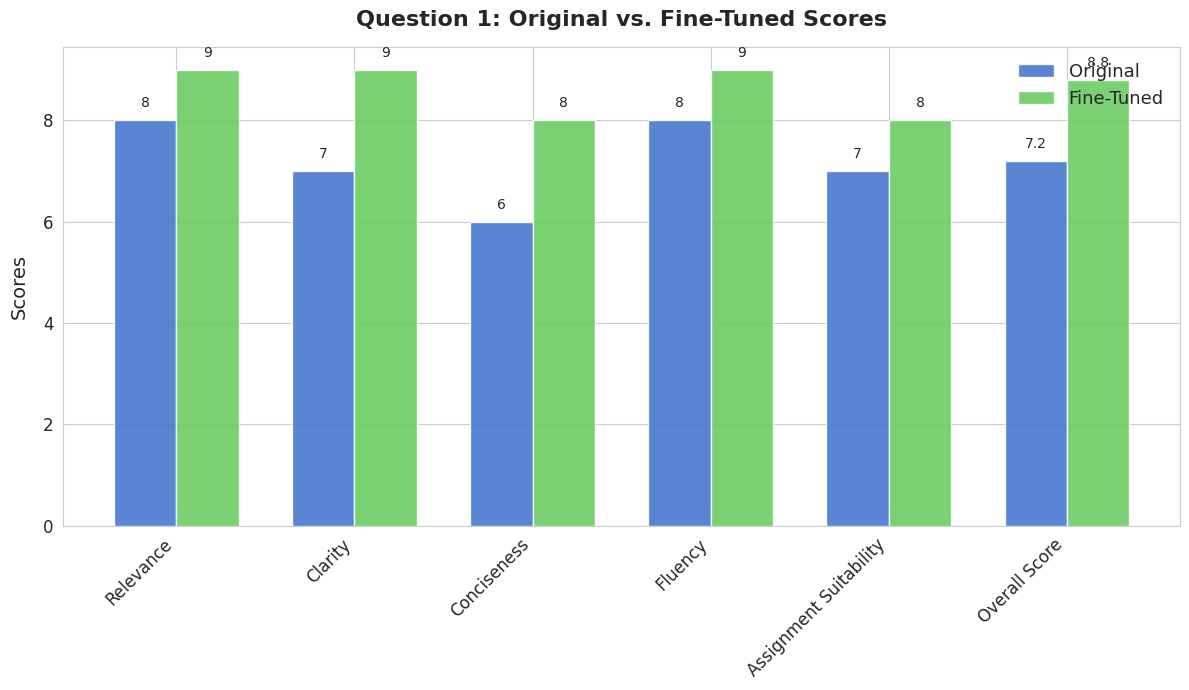

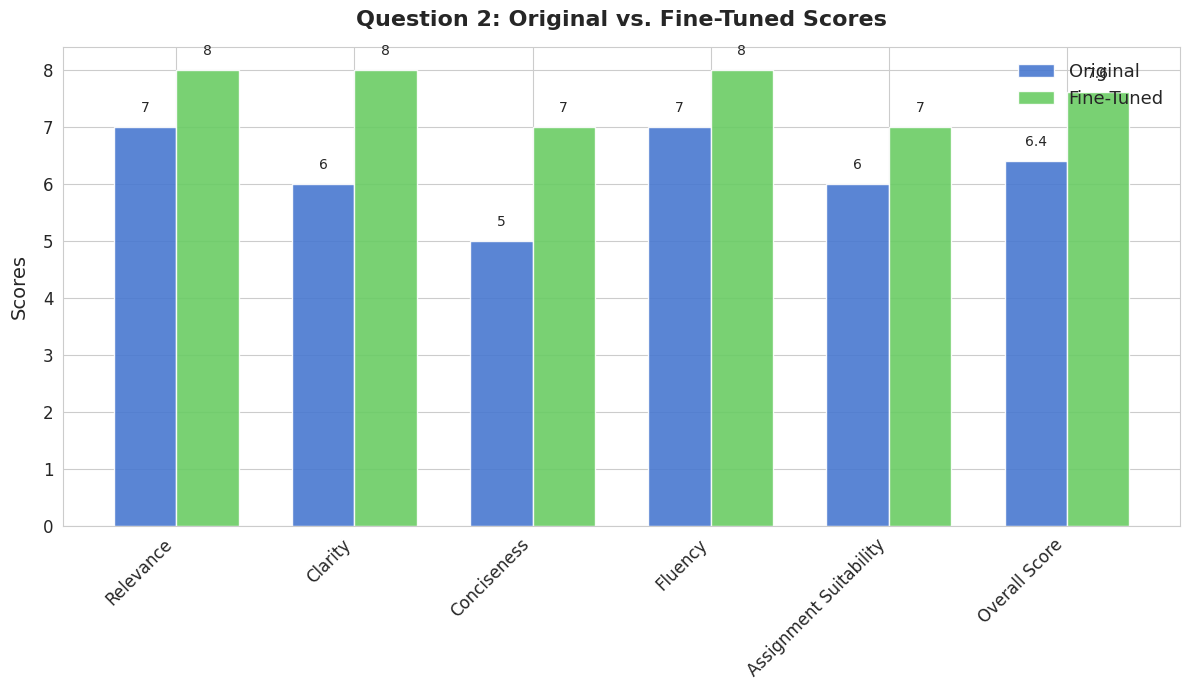

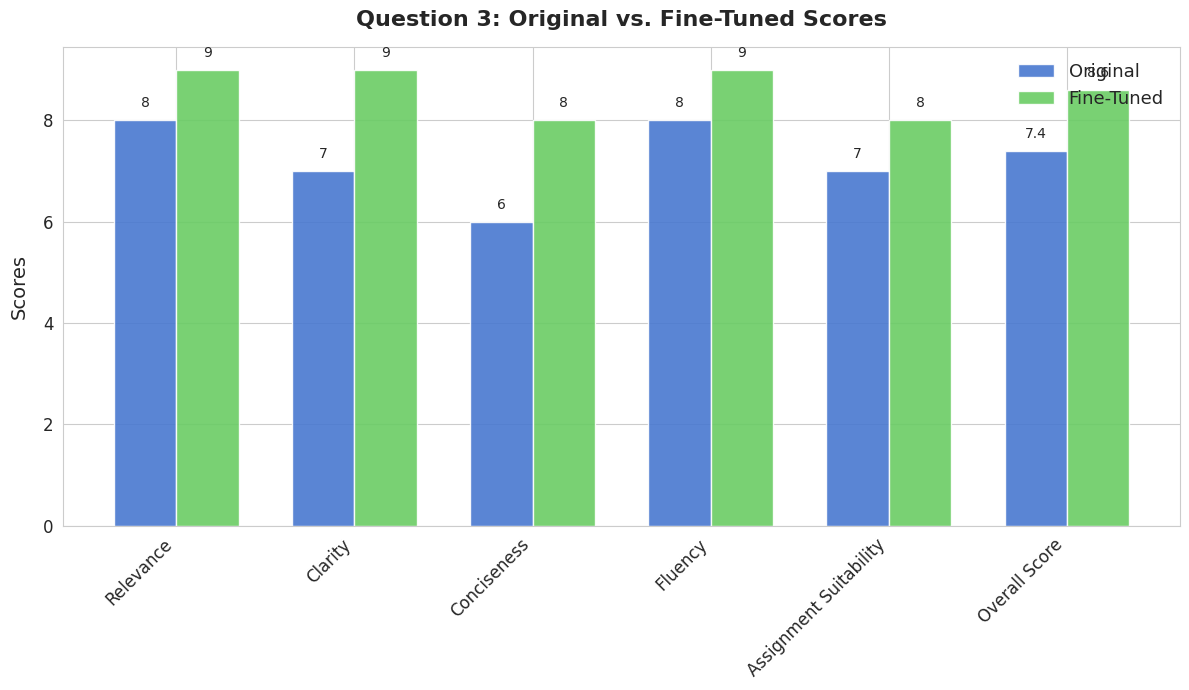

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def generate_bar_graph(question_data, question_number):
    """Generates a super nice and clean bar graph comparing original vs. fine-tuned scores."""

    original_scores = list(question_data["Original Response Scores"].values())
    fine_tuned_scores = list(question_data["Fine-Tuned Response Scores"].values())
    metrics = list(question_data["Original Response Scores"].keys())

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(12, 7))  # Larger figure for better impact
    sns.set_style("whitegrid")  # Clean white grid background

    # Using a professional color palette from Seaborn
    original_color = sns.color_palette("muted")[0]  # Muted blue
    fine_tuned_color = sns.color_palette("muted")[2]  # Muted green

    plt.bar(x - width/2, original_scores, width, label='Original', color=original_color, alpha=0.9)
    plt.bar(x + width/2, fine_tuned_scores, width, label='Fine-Tuned', color=fine_tuned_color, alpha=0.9)

    plt.ylabel('Scores', fontsize=14, labelpad=10)  # Added labelpad for spacing
    plt.title(f'Question {question_number}: Original vs. Fine-Tuned Scores', fontsize=16, fontweight='bold', pad=15)  # Added pad for spacing

    plt.xticks(x, metrics, rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(fontsize=13, frameon=False)  # Removed frame for cleaner look

    # Adding value labels on top of bars
    for i, (orig, fine) in enumerate(zip(original_scores, fine_tuned_scores)):
        plt.text(x[i] - width/2, orig + 0.2, f'{orig}', ha='center', va='bottom', fontsize=10)
        plt.text(x[i] + width/2, fine + 0.2, f'{fine}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Question data (same as before)
evals = [
    {
        "Question": "Design a system to solve a constraint satisfaction problem. Provide a practical example of how the system can be used.",
        "Response Type": "coding",
        "Difficulty": "hard",
        "CLO": "Develop an algorithm to model and solve complex constraints in a programming system.",
        "Topic": "Constraint Satisfaction Problems",
        "chunkNumber": 12,
        "Original Response Scores": {
            "Relevance": 8,
            "Clarity": 7,
            "Conciseness": 6,
            "Fluency": 8,
            "Assignment Suitability": 7,
            "Overall Score": 7.2
        },
        "Fine-Tuned Response Scores": {
            "Relevance": 9,
            "Clarity": 9,
            "Conciseness": 8,
            "Fluency": 9,
            "Assignment Suitability": 8,
            "Overall Score": 8.8
        },
        "Improvement Percentage": "22%",
        "Final Verdict": "Fine-Tuned",
        "Feedback": "The fine-tuned response is more structured and concise, directly addressing the system design and example."
    },
    {
        "Question": "Design and implement a card game simulator in Python to compare the performance of the Averaging Over Clairvoyance (AOC) algorithm with MINIMAX and H-MINIMAX algorithms in solving card games with random missing information.",
        "Type": "code",
        "Difficulty": "medium",
        "CLO": "Analyze and compare the performance of different algorithms.",
        "Topic": "Card Game Simulator",
        "chunkNumber": 47,
        "Original Response Scores": {
            "Relevance": 7,
            "Clarity": 6,
            "Conciseness": 5,
            "Fluency": 7,
            "Assignment Suitability": 6,
            "Overall Score": 6.4
        },
        "Fine-Tuned Response Scores": {
            "Relevance": 8,
            "Clarity": 8,
            "Conciseness": 7,
            "Fluency": 8,
            "Assignment Suitability": 7,
            "Overall Score": 7.6
        },
        "Improvement Percentage": "19%",
        "Final Verdict": "Fine-Tuned",
        "Feedback": "The fine-tuned response is better organized and covers all implementation steps effectively."
    },
    {
        "Question": "Implement a Python function to implement the Min-Max algorithm for adversarial search in game-playing scenarios, including Alpha-Beta pruning.",
        "Type": "code",
        "Difficulty": "hard",
        "CLO": "Analyze the performance of a Min-Max algorithm with alpha-beta pruning.",
        "Topic": "Game Tree Search",
        "chunkNumber": 1,
        "Original Response Scores": {
            "Relevance": 8,
            "Clarity": 7,
            "Conciseness": 6,
            "Fluency": 8,
            "Assignment Suitability": 7,
            "Overall Score": 7.4
        },
        "Fine-Tuned Response Scores": {
            "Relevance": 9,
            "Clarity": 9,
            "Conciseness": 8,
            "Fluency": 9,
            "Assignment Suitability": 8,
            "Overall Score": 8.6
        },
        "Improvement Percentage": "16%",
        "Final Verdict": "Fine-Tuned",
        "Feedback": "The fine-tuned response provides a clearer structure and more concise explanation of the algorithm."
    }
]

# Generate graphs for each question
generate_bar_graph(evals[0], 1)
generate_bar_graph(evals[1], 2)
generate_bar_graph(evals[2], 3)